# makemore: part 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)  * (5/3)/((n_embd * block_size)**0.5) #* 0.2
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # instead of 0, we want some entropy
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 # want the logits to be around zeros at the beginning

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


tensor(-0.0107) tensor(1.0027)
tensor(0.0004) tensor(0.9887)


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00, 5.0000e+00,
        4.0000e+00, 5.0000e+00, 6.0000e+00, 1.3000e+01, 1.2000e+01,
        2.2000e+01, 2.0000e+01, 4.0000e+01, 6.2000e+01, 7.0000e+01,
        1.0200e+02, 1.3500e+02, 2.1300e+02, 2.5800e+02, 2.9600e+02,
        4.1700e+02, 5.4700e+02, 6.7200e+02, 9.5400e+02, 1.1620e+03,
        1.5690e+03, 1.9650e+03, 2.3100e+03, 2.9990e+03, 3.6320e+03,
        4.4210e+03, 5.2410e+03, 6.0260e+03, 7.0260e+03, 8.0040e+03,
        8.8810e+03, 9.7380e+03, 1.0492e+04, 1.0831e+04, 1.1348e+04,
        1.1419e+04, 1.1023e+04, 1.0507e+04, 9.8560e+03, 9.0410e+03,
        8.0770e+03, 7.1110e+03, 6.0770e+03, 5.2450e+03, 4.3740e+03,
        3.6420e+03, 2.9150e+03, 2.4400e+03, 1.9300e+03, 1.5430e+03,
        1.2670e+03, 9.5700e+02, 7.7300e+02, 5.8200e+02, 4.0800e+02,
        3.3100e+02, 2.6100e+02, 1.9000e+02, 1.32

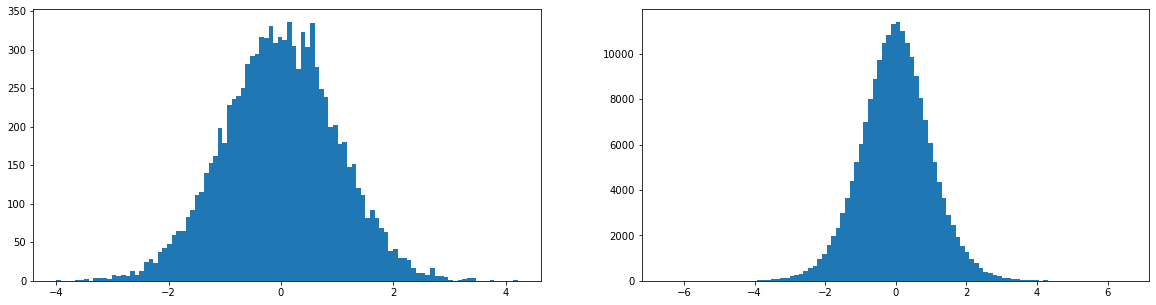

In [7]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.flatten(), bins=100)
plt.subplot(1, 2, 2)
plt.hist(y.flatten(), bins=100)

In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  # hpreact = embcat @ W1 + b1 # b1 has no gradient: print(b1.grad) will show None
  hpreact = embcat @ W1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  # hpreact = (hpreact - bnmeani) / bnstdi
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  # todo: print(f'{logits=}') to see the confidently wrong phenomenon
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  break

      0/ 200000: 3.3239


(array([153., 196., 174., 171., 173., 173., 131., 138., 130., 124., 113.,
        140., 124., 113., 109., 120., 120., 104., 123., 105., 105., 104.,
         94., 117., 111., 111.,  85.,  88.,  72.,  98.,  94., 127., 105.,
         88., 111., 110., 127., 112., 103., 124., 134., 130., 132., 149.,
        151., 179., 158., 192., 196., 159.]),
 array([-9.97799933e-01, -9.57872003e-01, -9.17944074e-01, -8.78016144e-01,
        -8.38088214e-01, -7.98160285e-01, -7.58232355e-01, -7.18304425e-01,
        -6.78376496e-01, -6.38448566e-01, -5.98520637e-01, -5.58592707e-01,
        -5.18664777e-01, -4.78736848e-01, -4.38808918e-01, -3.98880988e-01,
        -3.58953059e-01, -3.19025129e-01, -2.79097199e-01, -2.39169270e-01,
        -1.99241340e-01, -1.59313411e-01, -1.19385481e-01, -7.94575512e-02,
        -3.95296216e-02,  3.98308039e-04,  4.03262377e-02,  8.02541673e-02,
         1.20182097e-01,  1.60110027e-01,  2.00037956e-01,  2.39965886e-01,
         2.79893816e-01,  3.19821745e-01,  3.59749

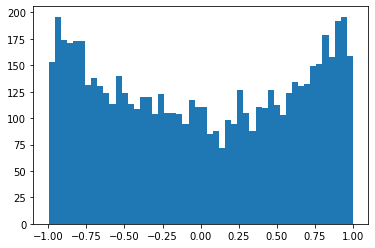

In [9]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   1.,   2.,   3.,   4.,  12.,  11.,  22.,  31.,  33.,  52.,
         79.,  97., 113., 148., 160., 232., 224., 254., 293., 335., 339.,
        368., 358., 360., 313., 327., 337., 275., 282., 237., 217., 198.,
        142., 135., 112.,  70.,  66.,  35.,  48.,  27.,  19.,  13.,   4.,
          5.,   3.,   1.,   1.,   0.,   1.]),
 array([-3.40565395, -3.26492825, -3.12420254, -2.98347683, -2.84275112,
        -2.70202541, -2.56129971, -2.420574  , -2.27984829, -2.13912258,
        -1.99839687, -1.85767117, -1.71694546, -1.57621975, -1.43549404,
        -1.29476833, -1.15404263, -1.01331692, -0.87259121, -0.7318655 ,
        -0.59113979, -0.45041409, -0.30968838, -0.16896267, -0.02823696,
         0.11248875,  0.25321445,  0.39394016,  0.53466587,  0.67539158,
         0.81611729,  0.95684299,  1.0975687 ,  1.23829441,  1.37902012,
         1.51974583,  1.66047153,  1.80119724,  1.94192295,  2.08264866,
         2.22337437,  2.36410007,  2.50482578,  2.64555149,  2.7862772 ,
 

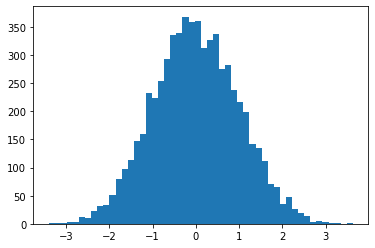

In [10]:
plt.hist(hpreact.view(-1).tolist(), 50)

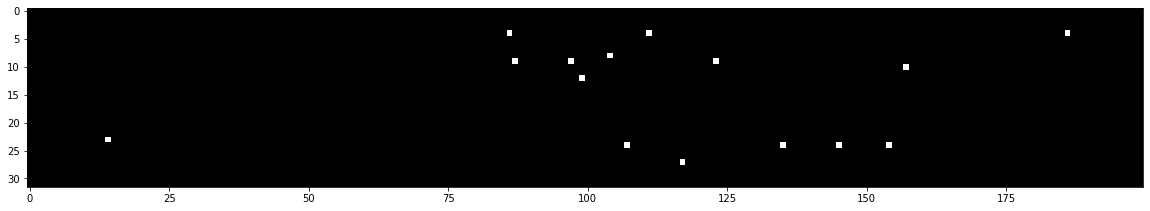

In [11]:
plt.figure(figsize=(20, 10))
plt.imshow(h > 0.99, cmap='gray', interpolation='nearest')

In [12]:
-torch.tensor(1/27).log()

tensor(3.2958)

In [13]:
# logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
logits = torch.randn(4) * 100
probs = F.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ 42.7083,  13.2543, 164.5708, -52.5666]),
 tensor([0., 0., 1., 0.]),
 tensor(-0.))

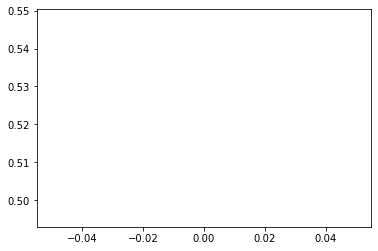

In [14]:
plt.plot(lossi)

In [15]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [16]:
bnstd[:, :10]

tensor([[1.6840, 1.1235, 1.6279, 1.4772, 1.8441, 1.3804, 1.0839, 1.2039, 1.8157,
         1.2710]])

In [17]:
bnstd_running[:, :10]

tensor([[1.0006, 1.0000, 1.0007, 1.0002, 1.0006, 1.0004, 1.0006, 1.0002, 1.0006,
         1.0002]])

In [18]:
bnmean[0, :10]

tensor([-0.4843, -0.1546, -0.9632,  0.6994,  0.7236,  0.5970,  1.1611, -0.7325,
        -0.4784,  0.3682])

In [19]:
bnmean_running[0, :10] # should be close to the above

tensor([-3.6745e-04, -7.2442e-06, -1.2061e-03,  1.3699e-03,  1.0505e-03,
         2.8725e-04,  1.1346e-03, -8.7319e-04, -7.2080e-04,  3.6078e-04])

In [20]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y) # reduction='mean' by default
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.270019769668579
val 3.269137144088745


## loss log

### original:
train 2.1245384216308594
val   2.168196439743042

### fix softmax confidently wrong:
train 2.07
val   2.13

### fix tanh layer too saturated at init:
train 2.0355966091156006
val   2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693
val   2.106989622116089

### add batch norm layer
train 2.0668270587921143
val 2.104844808578491


In [21]:
# SUMMARY + PYTORCHIFYING -----------

In [241]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.weight = torch.zeros((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# C = torch.zeros((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]
# layers = [
#   Linear(n_embd * block_size, n_hidden), 
#   Linear(           n_hidden, n_hidden), 
#   Linear(           n_hidden, n_hidden), 
#   Linear(           n_hidden, n_hidden), 
#   Linear(           n_hidden, n_hidden),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [242]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2958


In [243]:
parameters[-1].grad

tensor([ 0.0077, -0.0695,  0.0126,  0.0152,  0.0221, -0.0069, -0.0230,  0.0109,
         0.0313, -0.0172, -0.0176,  0.0200,  0.0305,  0.0253,  0.0149, -0.0603,
         0.0083,  0.0068, -0.0681,  0.0009, -0.0072,  0.0138,  0.0126,  0.0083,
         0.0078,  0.0090,  0.0115])

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

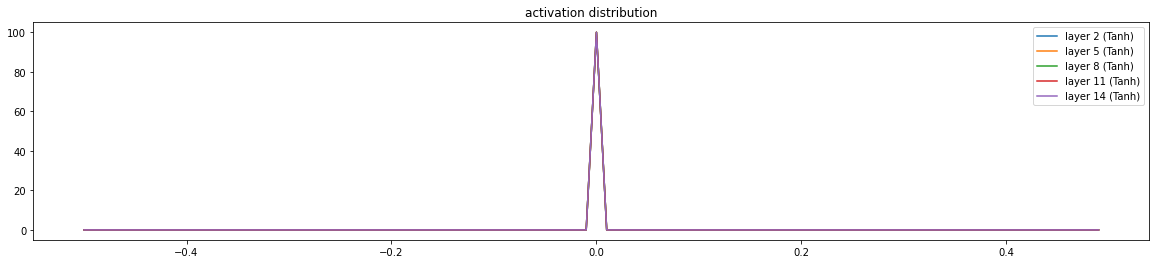

In [244]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

In [261]:
layers[-1].out

tensor([[ 1.7834,  1.8433, -0.6533, -0.5012, -0.0599,  1.2642, -1.0975, -0.7983,
          0.2440,  1.1233, -0.5439, -0.1324,  0.8544,  0.1146,  1.1818,  0.3426,
         -1.0497, -1.2619,  0.8508,  0.2861, -0.1306, -0.5461, -0.6744, -1.0733,
         -1.1991,  0.5834, -0.7501],
        [ 1.7834,  1.8433, -0.6533, -0.5012, -0.0599,  1.2642, -1.0975, -0.7983,
          0.2440,  1.1233, -0.5439, -0.1324,  0.8544,  0.1146,  1.1818,  0.3426,
         -1.0497, -1.2619,  0.8508,  0.2861, -0.1306, -0.5461, -0.6744, -1.0733,
         -1.1991,  0.5834, -0.7501],
        [ 1.7834,  1.8433, -0.6533, -0.5012, -0.0599,  1.2642, -1.0975, -0.7983,
          0.2440,  1.1233, -0.5439, -0.1324,  0.8544,  0.1146,  1.1818,  0.3426,
         -1.0497, -1.2619,  0.8508,  0.2861, -0.1306, -0.5461, -0.6744, -1.0733,
         -1.1991,  0.5834, -0.7501],
        [ 1.7834,  1.8433, -0.6533, -0.5012, -0.0599,  1.2642, -1.0975, -0.7983,
          0.2440,  1.1233, -0.5439, -0.1324,  0.8544,  0.1146,  1.1818,  0.3426

In [262]:
layers[-1].beta

tensor([ 1.7834,  1.8433, -0.6533, -0.5012, -0.0599,  1.2642, -1.0975, -0.7983,
         0.2440,  1.1233, -0.5439, -0.1324,  0.8544,  0.1146,  1.1818,  0.3426,
        -1.0497, -1.2619,  0.8508,  0.2861, -0.1306, -0.5461, -0.6744, -1.0733,
        -1.1991,  0.5834, -0.7501], requires_grad=True)

layer 1 (BatchNorm1d): mean +0.000000, std 0.000000e+00
layer 4 (BatchNorm1d): mean +0.000000, std 0.000000e+00
layer 7 (BatchNorm1d): mean +0.000000, std 0.000000e+00
layer 10 (BatchNorm1d): mean +0.000000, std 0.000000e+00
layer 13 (BatchNorm1d): mean +0.000000, std 0.000000e+00
layer 16 (BatchNorm1d): mean +0.000000, std 5.721838e-03


Text(0.5, 1.0, 'gradient distribution')

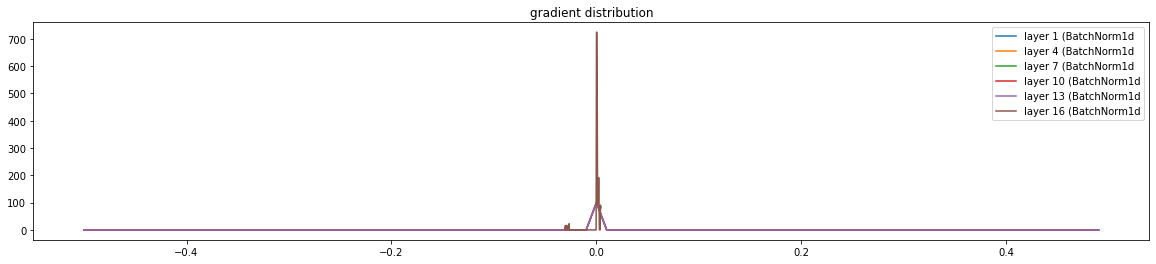

In [245]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers): # note: exclude the output layer
  if isinstance(layer, BatchNorm1d):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


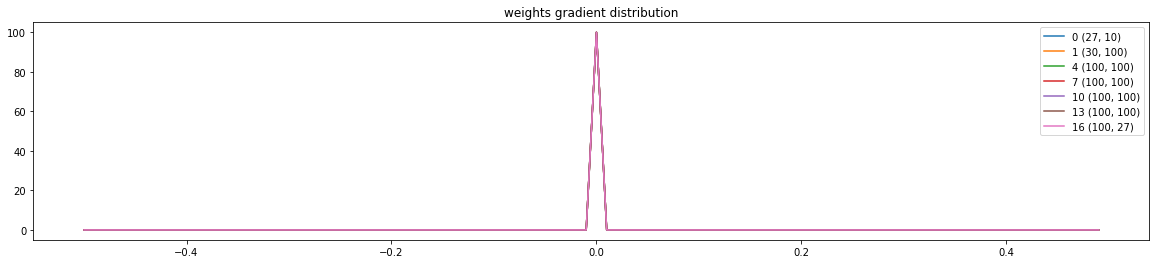

In [246]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

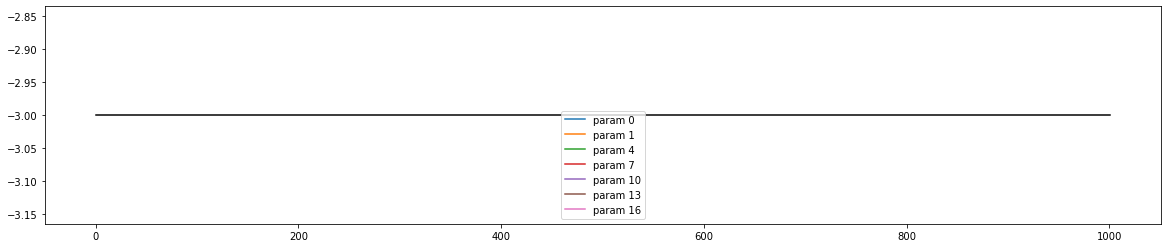

In [247]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
leg = plt.legend(legends);

In [248]:
ud[0]

[-inf,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -inf,
 0.0]

In [249]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.833400249481201
val 2.832515001296997


In [250]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

narpahxqae.
hlrihkimrsxreaty.
hnaassnejr.
hnenfaperahc.
iaqei.
.
ermaia.
ceaiiv.
e.
lein.
h.
.
m.
.
oin.
qeijn.
s.
lilea.
.
aabq.


In [251]:
# DONE; BONUS content below, not covered in video

In [252]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [253]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item()) # std(x+y+z) = sqrt(std(x)^2 + std(y)^2 + std(z)^2) = sqrt(1000) = 31.6 in our case here
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item()) # similar to the std of c, for each term in a.grad, we have 1000 terms added together, leading to std of sqrt(1000)
print('b grad std:', b.grad.std().item()) # each term in b.grad is a sum of 1 term. See here on why std(x*y) = std(x)*std(y) https://math.stackexchange.com/questions/1416518/standard-deviation-of-the-product-of-gaussians

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [254]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559


In [255]:
# - E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

# y = Wx + b for the last linear layer, because W is zeros, there is no gradient flowing to x, the output of last layer. Because x is zeros, there's no gradient on W either. Only the bias b can be trained. Or the beta of the last batchnorm layer can be trained. The network can still train, but only partially.

# - E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [256]:

layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  # Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

6224


In [257]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2958


In [258]:
for layer in layers:
  layer.training = False

In [259]:
# sample from the model

context = [0] * block_size # initialize with all ...
x = emb.view(emb.shape[0], -1) # concatenate the vectors
for layer in layers:
    x = layer(x)
x

tensor([[ 1.7834,  1.8433, -0.6533, -0.5012, -0.0599,  1.2642, -1.0975, -0.7983,
          0.2440,  1.1233, -0.5439, -0.1324,  0.8544,  0.1146,  1.1818,  0.3426,
         -1.0497, -1.2619,  0.8508,  0.2861, -0.1306, -0.5461, -0.6744, -1.0733,
         -1.1991,  0.5834, -0.7501],
        [ 1.7834,  1.8433, -0.6533, -0.5012, -0.0599,  1.2642, -1.0975, -0.7983,
          0.2440,  1.1233, -0.5439, -0.1324,  0.8544,  0.1146,  1.1818,  0.3426,
         -1.0497, -1.2619,  0.8508,  0.2861, -0.1306, -0.5461, -0.6744, -1.0733,
         -1.1991,  0.5834, -0.7501],
        [ 1.7834,  1.8433, -0.6533, -0.5012, -0.0599,  1.2642, -1.0975, -0.7983,
          0.2440,  1.1233, -0.5439, -0.1324,  0.8544,  0.1146,  1.1818,  0.3426,
         -1.0497, -1.2619,  0.8508,  0.2861, -0.1306, -0.5461, -0.6744, -1.0733,
         -1.1991,  0.5834, -0.7501],
        [ 1.7834,  1.8433, -0.6533, -0.5012, -0.0599,  1.2642, -1.0975, -0.7983,
          0.2440,  1.1233, -0.5439, -0.1324,  0.8544,  0.1146,  1.1818,  0.3426

In [260]:
bn = layers[-1]
prev_linear = layers[-2]
std = torch.sqrt(bn.running_var + bn.eps)
prev_linear.weight = bn.gamma * prev_linear.weight / std
prev_linear.bias = bn.gamma * (- bn.running_mean) / std + bn.beta
layers2 = layers[:-1]

context = [0] * block_size # initialize with all ...
x = emb.view(emb.shape[0], -1) # concatenate the vectors
for layer in layers2:
    x = layer(x)
x

tensor([[ 1.7834,  1.8433, -0.6533, -0.5012, -0.0599,  1.2642, -1.0975, -0.7983,
          0.2440,  1.1233, -0.5439, -0.1324,  0.8544,  0.1146,  1.1818,  0.3426,
         -1.0497, -1.2619,  0.8508,  0.2861, -0.1306, -0.5461, -0.6744, -1.0733,
         -1.1991,  0.5834, -0.7501],
        [ 1.7834,  1.8433, -0.6533, -0.5012, -0.0599,  1.2642, -1.0975, -0.7983,
          0.2440,  1.1233, -0.5439, -0.1324,  0.8544,  0.1146,  1.1818,  0.3426,
         -1.0497, -1.2619,  0.8508,  0.2861, -0.1306, -0.5461, -0.6744, -1.0733,
         -1.1991,  0.5834, -0.7501],
        [ 1.7834,  1.8433, -0.6533, -0.5012, -0.0599,  1.2642, -1.0975, -0.7983,
          0.2440,  1.1233, -0.5439, -0.1324,  0.8544,  0.1146,  1.1818,  0.3426,
         -1.0497, -1.2619,  0.8508,  0.2861, -0.1306, -0.5461, -0.6744, -1.0733,
         -1.1991,  0.5834, -0.7501],
        [ 1.7834,  1.8433, -0.6533, -0.5012, -0.0599,  1.2642, -1.0975, -0.7983,
          0.2440,  1.1233, -0.5439, -0.1324,  0.8544,  0.1146,  1.1818,  0.3426